# Masked Autoencoders (MAE)

- paper : https://arxiv.org/abs/2111.06377
- official code : https://github.com/facebookresearch/mae/tree/main






- Vision Transformer tutorial :https://github.com/seonm9119/tutorials/blob/main/Vision%20Transformer.ipynb
-BERT : https://github.com/seonm9119/tutorials/blob/main/BERT.ipynb


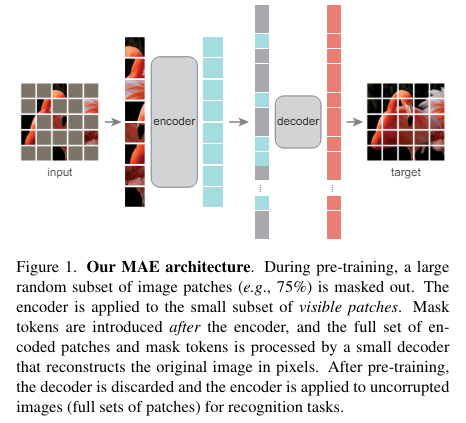

BERT가 발표된후, 컴퓨터 비전에서도 마스킹을 이용한 다양한 논문이 발표되었다. MAE는 그 중 하나이다. 논문의 핵심 아이디어는 토큰을 마스킹하고 디코더에서 reconstruct하여 모델을 학습시킨다. 이때, 인코더에서는 마스킹된 토큰을 사용하지 않음으로서 연산량을 줄였다.

여담으로 CVPR 2022에 비슷한 아이디어로 두 논문이 발표된다. MAE, SimMIM. 두 논문 모두 토큰을 마스킹하고 reconstuct하는 방식으로 모델을 학습한다. 그런데 재미난 부분은 2022년도이면, 이미 계층 모델 Swin, PvT등 다양한 백본이 발표되었던 시점인데, MAE는 백본으로 ViT를 채택하고, SimMIM은 Swin을 채택한다.

# Let's GO!

### Setup Codes

In [ ]:
%load_ext autoreload
%autoreload 2

#### Google Colab Setup
we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section. Run the following cell to mount your Google Drive.

In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 'Test' folder and put all the files under 'example' folder, then 'Test/example'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Test/example'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'GIT/tutorials/utils/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

print(os.listdir(GOOGLE_DRIVE_PATH))

#### Import packages

In [ ]:
!pip install einops
!pip install timm

In [ ]:
import torch
import torch.nn as nn

### Load Datasets

we will be working on the CIFAR-100, CIFAR-10 dataset, which has 60,000 training and 10,000 test images. we will use the PyTorch CIFAR-100, CIFAR-10 wrapper. See the [documentation](https://github.com/pytorch/vision/blob/main/torchvision/datasets/cifar.py) for more information about the interface.

In [ ]:
from torch.utils.data import DataLoader

# custom packages
from data.cifar import CIFAR100, CIFAR10

In [ ]:
# for pre-train
train_dataset = CIFAR100(root='.', train=True, image_size=32)

pre_train = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
# for fine-tune
train_dataset = CIFAR10(root='.', train=True, image_size=32)
test_dataset = CIFAR10(root='.', train=False, image_size=32)

fine_tune = {}
fine_tune['train'] = DataLoader(train_dataset, batch_size=128, shuffle=True)
fine_tune['test'] = DataLoader(test_dataset, batch_size=128, shuffle=False)

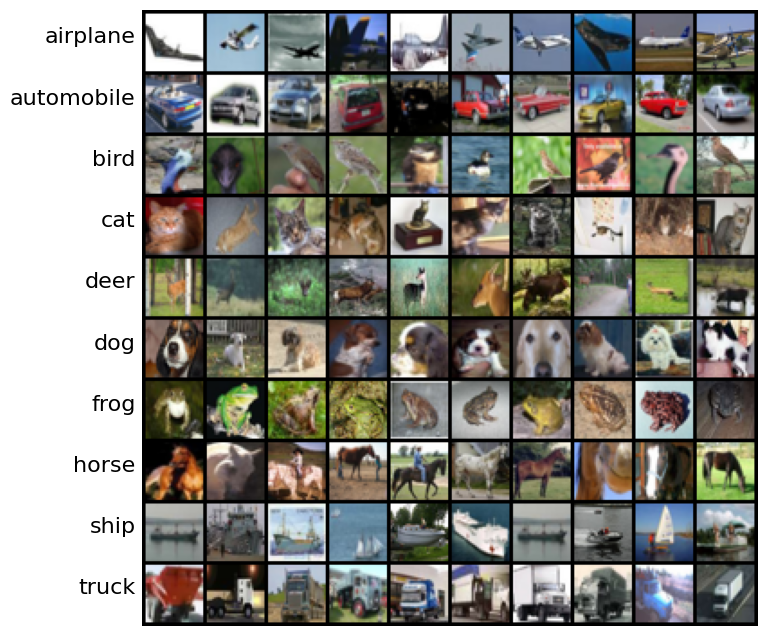

In [ ]:
train_dataset.visualize_dataset(samples_per_class=10)

## Build a Masked Autoencoder

In [ ]:
from einops.layers.torch import Rearrange

# custom packages
from models.vit.blocks import Block
from models.vit.sublayers import PatchEmbed

In [ ]:
def random_masking(x, mask_ratio):

    N, L, D = x.shape
    len_keep = int(L * (1 - mask_ratio))

    noise = torch.rand(N, L, device=x.device)

    ids_shuffle = torch.argsort(noise, dim=1)
    ids_restore = torch.argsort(ids_shuffle, dim=1)

    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, mask, ids_restore

In [ ]:
class Encoder(nn.Module):
  def __init__(self,
               img_size=224,
               in_chans=3,
               patch_size=16,
               mlp_ratio=4,
               dropout=0.1,
               embed_dim=1024,
               num_heads=16,
               depth=24):
      super().__init__()


      self.pos_drop = nn.Dropout(dropout)
      self.norm = nn.LayerNorm(embed_dim)


      self.patch_embed = PatchEmbed(img_size=img_size,
                                      patch_size=patch_size,
                                      in_chans=in_chans,
                                      embed_dim=embed_dim)

      num_patches = self.patch_embed.num_patches
      self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
      self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

      self.blocks = nn.Sequential(*[Block(dim=embed_dim,
                                          num_heads=num_heads,
                                          mlp_ratio=mlp_ratio,
                                          drop_path=dropout) for _ in range(depth)])


  def forward(self, x, mask_ratio):

    x = self.patch_embed(x)
    x += self.pos_embed[:, 1:, :]
    x, mask, ids_restore = random_masking(x, mask_ratio)

    cls_token = self.cls_token + self.pos_embed[:, :1, :]
    cls_token = cls_token.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_token, x), dim=1)

    x = self.blocks(x)
    return self.norm(x), mask, ids_restore

In [ ]:
class Decoder(nn.Module):
  def __init__(self,
               input_dim,
               img_size=224,
               in_chans=3,
               patch_size=16,
               mlp_ratio=4,
               dropout=0.1,
               embed_dim=1024,
               num_heads=16,
               depth=24):
      super().__init__()


      self.dropout = nn.Dropout(dropout)
      self.norm = nn.LayerNorm(embed_dim)

      # not patch embedding, embed of latent
      self.embedding = nn.Linear(input_dim, embed_dim)

      # to restore a mask tokens, encoder hasn't mask tokens
      self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

      num_patches = img_size * img_size // patch_size ** 2
      self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
      self.blocks = nn.Sequential(*[Block(dim=embed_dim,
                                          num_heads=num_heads,
                                          mlp_ratio=mlp_ratio,
                                          drop_path=dropout) for _ in range(depth)])

      # resotre tokens
      self.pred = nn.Linear(embed_dim, patch_size**2 * in_chans)

  def forward(self, x, ids_restore):

        x = self.embedding(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))
        x = torch.cat([x[:, :1, :], x_], dim=1)

        x += self.pos_embed
        x = self.blocks(x)
        x = self.norm(x)

        # predictor projection
        x = self.pred(x)[:, 1:, :]
        return x



In [ ]:
class MAE(nn.Module):
  def __init__(self,
               img_size=224,
               in_chans=3,
               patch_size=16,
               mlp_ratio=4,
               dropout=0.1,
               enc_dim=1024,
               enc_head=16,
               enc_depth=24,
               dec_dim=1024,
               dec_head=16,
               dec_depth=24):
      super().__init__()

      self.encoder = Encoder(img_size=img_size,
                             in_chans=in_chans,
                             patch_size=patch_size,
                             mlp_ratio=mlp_ratio,
                             dropout=dropout,
                             embed_dim=enc_dim,
                             num_heads=enc_head,
                             depth=enc_depth)

      self.decoder = Decoder(input_dim=enc_dim,
                             img_size=img_size,
                             in_chans=in_chans,
                             patch_size=patch_size,
                             mlp_ratio=mlp_ratio,
                             dropout=dropout,
                             embed_dim=dec_dim,
                             num_heads=dec_head,
                             depth=dec_depth)


  def forward(self, imgs, mask_ratio=0.5):

    latent, mask, ids_restore = self.encoder(imgs, mask_ratio)
    pred = self.decoder(latent, ids_restore)  # [N, L, p*p*3]
    return pred, mask

In [ ]:
def patchify(imgs, patch_size, channel=3):
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], channel, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * channel))
    return x



In [ ]:
def unpatchify(x, patch_size, channel=3):
    p = patch_size
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]

    x = x.reshape(shape=(x.shape[0], h, w, p, p, channel))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], channel, h * p, h * p))
    return imgs

In [ ]:
def loss_function(imgs, pred, mask):
  target = patchify(imgs, patch_size=4)

  loss = (pred - target) ** 2
  loss = loss.mean(dim=-1)

  loss = (loss * mask).sum() / mask.sum()
  return loss


## Train a Net

위에서 구현한 모델은 논문의 핵심 개념을 이해하기 쉽도록 간단히 구현한 것이다. 스케줄러, 초기 가중치 설정 등의 세부 사항은 논문과 공식 코드를 참고하여 모델을 더 구체화하길 권장한다. 그럼 구현한 모델을 학습시켜 보자!

In [ ]:
from datetime import datetime

# custom packages
from models.vision_transformer import VisionTransformer
import colab_utils.vit as vit
import colab_utils.mae as mae

일반적으로 사전 학습 단계에서는 대규모 데이터셋인 ImageNet을 사용한다. 하지만 우리는 간단한 테스트를 해보기위해 CIFAR-100을 사용하여 모델을 사전 학습시킨다.

In [ ]:
pre_model = MAE(img_size=32,
                in_chans=3,
                patch_size=4,
                mlp_ratio=4.,
                dropout=0.1,
                enc_dim=512,
                enc_head=8,
                enc_depth=12,
                dec_dim=256,
                dec_head=8,
                dec_depth=4)

optimizer = torch.optim.AdamW(pre_model.parameters(), lr=1e-3)

In [ ]:
history = mae.runner(pre_model, loss_function, optimizer, pre_train, num_epochs=10, msg=2)
torch.save(pre_model.encoder.state_dict(), 'pre_train.pth')

Train using cuda
Epoch [2/10]          time: 0:03:28          train Loss: 0.7379          
Epoch [4/10]          time: 0:03:30          train Loss: 0.5478          
Epoch [6/10]          time: 0:03:31          train Loss: 0.4945          
Epoch [8/10]          time: 0:03:30          train Loss: 0.4600          
Epoch [10/10]          time: 0:03:30          train Loss: 0.4366          

Finished Training
Toral Training Time: 0:17:31


학습된 모델을 활용하여 다운스트림 태스크로 CIFAR-10의 Classification을 수행해보자!

In [ ]:
fine_model = VisionTransformer(img_size=32,
                               patch_size=4,
                               in_chans=3,
                               num_classes=10,
                               embed_dim=512,
                               depth=12,
                               num_heads=8, )


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fine_model.parameters(), lr=1e-4)

In [ ]:
checkpoint = torch.load("pre_train.pth")
fine_model.load_state_dict(checkpoint, strict=False)

_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])

In [ ]:
history = vit.runner(fine_model, criterion, optimizer, fine_tune, num_epochs=5, msg=1)
torch.save(fine_model.state_dict(), 'fine_tune.pth')

Train using cuda
Epoch [1/5]          time: 0:04:17          train Loss: 2.2373          train ACC: 31.22%          val Loss: 1.5752          val ACC: 43.71%
Epoch [2/5]          time: 0:04:17          train Loss: 1.5029          train ACC: 46.93%          val Loss: 1.4706          val ACC: 48.10%
Epoch [3/5]          time: 0:04:17          train Loss: 1.4024          train ACC: 50.71%          val Loss: 1.3939          val ACC: 50.50%
Epoch [4/5]          time: 0:04:17          train Loss: 1.3518          train ACC: 52.35%          val Loss: 1.3484          val ACC: 52.20%
Epoch [5/5]          time: 0:04:17          train Loss: 1.3033          train ACC: 54.20%          val Loss: 1.3540          val ACC: 52.50%

Finished Training
Toral Training Time: 0:21:28
Accuracy of the test images: 52.50%
